In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
import matplotlib.pyplot as plt

from tqdm import tqdm

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'src'))

warnings.filterwarnings('ignore')

# Closed Loop implemented as Neural ODE on a mesh

Initializing
Loaded mesh gradient operators
Using scipy solve_ivp
Done


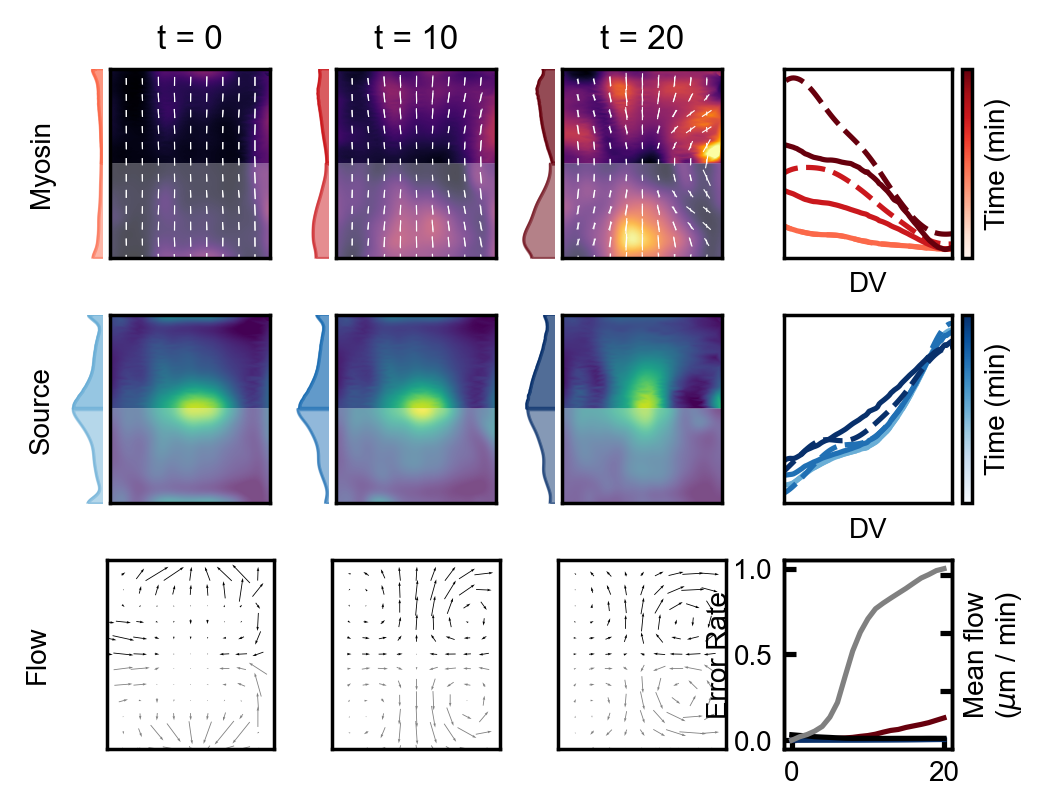

In [47]:
from fenics import FiniteElement, VectorElement

from scipy import sparse
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from torchdiffeq import odeint

from utils.forecasting.closed_loop import ClosedFlyLoop
from utils.forecasting.transforms import *
from utils.forecasting.plot_utils import *
from utils.geometry.geometry_utils import *
from utils.geometry.fenics_utils import *
from utils.decomposition.decomposition_model import *

class MeshInputProcessor(InputProcessor):
    '''
    Processes inputs on a mesh and shapes them correctly
    '''
    def __init__(self, mesh=embryo_mesh):
        self.mesh = mesh
    
    def fit(self, X, y=None):
        x = X.reshape([-1, self.mesh.coordinates().shape[0]])
        self.n_components_ = x.shape[0]
        self.data_shape_ = x.shape[1:]
        
        if torch.is_tensor(X):
            self.mode_ = 'torch'
        else:
            self.mode_ = 'numpy'
        
        return self
    
class MeshGradient(BaseEstimator, TransformerMixin, torch.nn.Module):
    '''
    Compute gradients on an embryo mesh using fenics
    The inputs live in the tangent space but are defined on the mesh
    The outputs live in 3D space but are computed using the projected
        tangent operators
    The reason for this is that we can save some overhead by 
        iteratively re-using the vector element operators,
        rather than using a tensor or higher-order element operator,
        to compute gradients in each direction
    '''
    def __init__(self, mesh=embryo_mesh):
        torch.nn.Module.__init__(self)
        self.mesh = mesh
        self.pixel_scale = 0.2619
        
    def fit(self, X, y0=None):
        try:
            self.A_sca_ = sparse.load_npz('utils/geometry/A_scalar.npz')
            self.grad_sca_ = [sparse.load_npz(f'utils/geometry/grad_scalar_{i}.npz') \
                              for i in range(3)]
            
            self.A_vec_ = sparse.load_npz('utils/geometry/A_vector.npz')
            self.grad_vec_ = [sparse.load_npz(f'utils/geometry/grad_vector_{i}.npz') \
                              for i in range(3)]
            print('Loaded mesh gradient operators')
        
        except:
            print('Building mesh gradient operators')
            self.A_sca_, self.grad_sca_ = build_gradient_operators(
                FiniteElement('CG', embryo_mesh.ufl_cell(), 1))
            self.A_vec_, self.grad_vec_ = build_gradient_operators(
                VectorElement('CG', embryo_mesh.ufl_cell(), 1))
        
            print('Saving mesh gradient operators')
            sparse.save_npz('utils/geometry/A_scalar.npz', self.A_sca_)
            sparse.save_npz('utils/geometry/A_vector.npz', self.A_vec_)

            for i in range(3):
                sparse.save_npz(f'utils/geometry/grad_scalar_{i}.npz', self.grad_sca_[i])
                sparse.save_npz(f'utils/geometry/grad_vector_{i}.npz', self.grad_vec_[i])
            print('Done')
            
        return self
        
    def grad_scalar(self, X):
        grad = np.zeros([X.shape[-1], 3])
        for i in range(3):
            L = self.grad_sca_[i].dot(X.flatten())
            d = self.A_sca_.dot(L)
            grad[..., i] = d
        return grad
    
    def grad_vector(self, X):
        grad = np.zeros([3, X.shape[-1], 3])
        for i in range(3):
            L = self.grad_vec_[i].dot(X.flatten())
            d = self.A_vec_.dot(L)
            grad[..., i] = pull_vector_from_tangent_space(d)
        return grad
    
    def grad_tensor(self, X):
        grad = np.zeros([3, 3, X.shape[-1], 3])
        d_i = np.zeros([*X.shape])
        for i in range(3):
            for j in range(2):
                L = self.grad_vec_[i].dot(X[j].flatten())
                d = self.A_vec_.dot(L)
                d_i[j] = d.reshape(X[j].shape)
            d_i = 0.5 * (d_i + d_i.transpose(1, 0, 2))
            grad[..., i] = pull_tensor_from_tangent_space(d_i)
        return grad
        
    def transform(self, X):
        n_components = np.prod(X.shape[:-1])
        
        if n_components == 1:
            grad = self.grad_scalar(X)
        elif n_components == 2:
            grad = self.grad_vector(X)
        elif n_components == 4:
            grad = self.grad_tensor(X)
            
        grad = grad / self.pixel_scale
            
        return grad

    def forward(self, X):
        return self.transform(X)
        
class ClosedLoopMesh(ClosedFlyLoop):
    '''
    A similar neural ODE model whose fields live on the mesh, rather than
    in the embryo grid
    
    However, to ensure we remain confined to the surface, all of the 
    dynamics will be projected onto the tangent space
    
    TODO: 
        - [x] Input shaping to use vertices over grid
        - [x] Gradients are taken on the mesh surface
        - [ ] Push mesh values to grid points to compute flow from myosin
        - [x] Convert einsum to use vertices over grid points
        - [x] Velocity model pushes tangent space flow to the 3D embryo 
    '''
    def __init__(self,
                 mesh=embryo_mesh,
                 v_model=None,
                 v_thresh=0,
                 sigma=3,
                 dv_mode='circular',
                 ap_mode='replicate'):
        super().__init__(v_model, v_thresh, sigma, dv_mode, ap_mode)
        self.mesh = mesh
        
    def fit(self, X, y0=None):
        self.inputs = MeshInputProcessor(self.mesh).fit(X)
        self.gradient = MeshGradient(self.mesh).fit(X)
        self.smoother = EmbryoSmoother(sigma=self.sigma, dv_mode=self.dv_mode, ap_mode=self.ap_mode).fit(X)
        
        gamma_dv = np.zeros([2, 2, *self.inputs.data_shape_])
        gamma_dv[0, 0, ...] = 1.
        self.gamma_dv_ = pull_from_tangent_space(gamma_dv)
        
        if torch.is_tensor(X):
            self.mode_ = 'torch'
            self.einsum_ = torch.einsum
            self.gamma_dv_ = torch.nn.Parameter(
                torch.from_numpy(self.gamma_dv_),
                requires_grad=False)
        else:
            self.mode_ = 'numpy'
            self.einsum_ = np.einsum
        
    def get_velocity(self, t, y):
        v = self.v_model(t, y)
        return v

    def forward(self, t, y):
        m, s = self.inputs.transform(y)
        
        v = self.get_velocity(t, y).squeeze()
        
        #Gradients are computed in tangent space and projected to 3D
        d1_m = self.gradient(m).reshape([3, 3, -1, 3])
        d1_s = self.gradient(s).reshape([-1, 3])
        d1_v = self.gradient(v).reshape([3, -1, 3])
        
        #Project fields themselves to 3D
        s = pull_from_tangent_space(s)
        v = pull_from_tangent_space(v)
        m = pull_from_tangent_space(m)
                
        sdot = -self.einsum_('iv,vi->v', v, d1_s)
        
        O = -0.5 * (self.einsum_('ivj->ijv', d1_v) - \
                    self.einsum_('ivj->jiv', d1_v))
        E =  0.5 * (self.einsum_('ivj->ijv', d1_v) + \
                    self.einsum_('ivj->jiv', d1_v))
    
        lhs  = self.einsum_('kv,ijvk->ijv', v, d1_m)
        lhs += self.einsum_('ikv,kjv->ijv', O, m)
        lhs -= self.einsum_('ikv,kjv->ijv', m, O)
        rhs  = self.rhs(m, s, v, E)
        mdot = -lhs + rhs
        
        #Project back to tangent space
        mdot = push_to_tangent_space(mdot, grid=False).reshape([2, 2, -1])
        sdot = push_to_tangent_space(sdot, grid=False)
        
        #Postprocess
        mdot = self.postprocess(mdot)
        sdot = self.postprocess(sdot)
                
        ydot = self.inputs.inverse_transform(mdot, sdot)
        return ydot
    
    def postprocess(self, f, nDV=54, nAP=46, dv_cut=2, ap_cut=3):
        c = f.shape[:-1]
        f = interpolate_mesh_vertices_to_grid(f, nDV=nDV, nAP=nAP)

        #Cut off poles
        f = f[..., dv_cut:-dv_cut, ap_cut:-ap_cut]
        
        #Smooth
        f = self.smoother.transform(f)
        
        f = f.reshape([*c, *f.shape[-2:]])
        f = interpolate_grid_to_mesh_vertices(f)
        return f

    def rhs(self, m, s, v, E):
        trm = self.einsum_('kkv->v', m)
        trE = self.einsum_('kkv->v', E)
        smean = s.mean()
        
        rhs  = -(0.066 - 0.061 * s) * m
        rhs +=  (0.489 + 0.318 * s) * m * trE
        rhs +=  (0.564 - 0.393 * s) * trm * m
        rhs +=  (0.047 - 0.037 * s) * trm * self.gamma_dv_
        return rhs
    
    
#Collect initial conditions - m, c, v, and time
with h5py.File('Public/myosin_dynamics_fitting.h5', 'r') as h5f:
    data = h5f['ensemble']
    tmin, tmax = 0, 20
    
    t = data['fields/v'].attrs['t']
    t_mask = np.logical_and(t >= tmin, t <= tmax)
    m0 = data['fields/m_ij'][t_mask, ...][()]
    s0 = data['fields/c'][t_mask, ...][()]
    s0 = LeftRightSymmetrize().fit_transform(s0)
    v0 = data['fields/v'][t_mask, ...][()]
    t0 = t[t_mask, ...][()]

#Using a flow field interpolator in the loop instead of a neural network

v_verts = np.stack([
    interpolate_grid_to_mesh_vertices(v0[i, ..., 10:-10]) for i in range(len(v0))
])
v_int = interp1d(t0, 
                 v_verts, 
                 axis=0, fill_value='extrapolate')
v_model = lambda t, y: v_int(t)

y0 = np.concatenate([
    interpolate_grid_to_mesh_vertices(m0[0]).reshape([4, 1797]),
    interpolate_grid_to_mesh_vertices(s0[0]).reshape([1, 1797]),
])


model = ClosedLoopMesh(v_model=v_model, sigma=.5)
m, s, v = model.integrate(y0, t0)
print('Done')

m = np.stack([interpolate_mesh_vertices_to_grid(m[i]) for i in range(len(m))])
s = np.stack([interpolate_mesh_vertices_to_grid(s[i]) for i in range(len(s))])
v = np.stack([interpolate_mesh_vertices_to_grid(v[i]) for i in range(len(v))])

#sqh_vel_plot(m, v, t0, dt=5)
comparison_plot(t0,
                ('Myosin', m, m0),
                ('Source', s, s0),
                ('Flow', v, v0),
                dt=10)

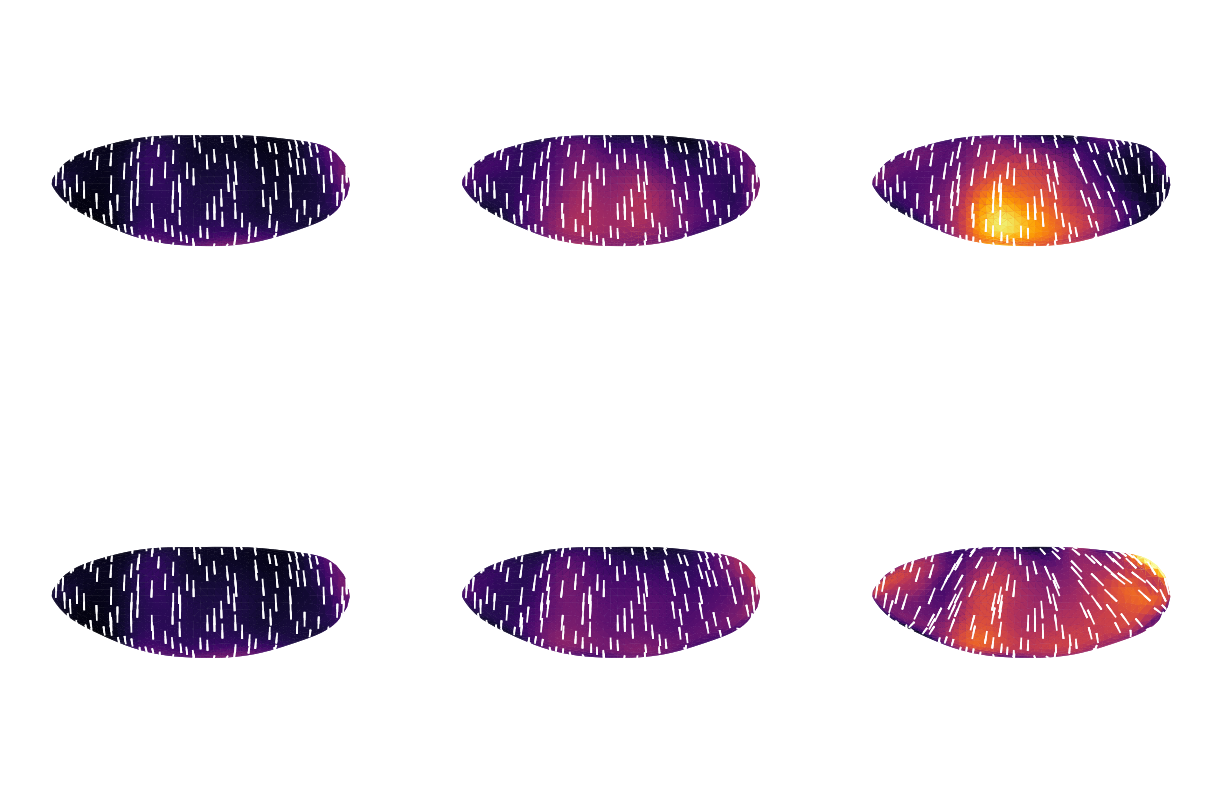

In [48]:
from utils.geometry.plot_utils import *
fig, ax = plt.subplots(2, 3, dpi=250, subplot_kw=dict(projection='3d'))

mnorm = np.linalg.norm(m0, axis=(1, 2))
vmin, vmax = np.min(mnorm), np.max(mnorm)

for i in range(3):
    plot_tensor3D(ax[0, i], pull_from_tangent_space(m0[i*10]), vmin=vmin, vmax=vmax)
    plot_tensor3D(ax[1, i], pull_from_tangent_space(m[i*10].reshape([2, 2, 236, 200])), vmin=vmin, vmax=vmax)

In [111]:
from utils.geometry.geometry_utils import embryo_mesh
from fenics import MeshEditor

verts = embryo_mesh.coordinates()
pix_scale = 0.2619
verts = verts * pix_scale

ptp = np.ptp(verts, axis=0)
radius = np.mean(ptp[:2]/2)

print(f'3D Embryo: radius={radius:.3g}, circumference={2*np.pi*radius:.3g}, length={ptp[2]:.3g} (all in microns)')
print(f'2D Embryo: circumference={dv_max-dv_min:.3g}, length={ap_max-ap_min:.3g} (all in microns)')

3D Embryo: radius=86.7, circumference=545, length=455 (all in microns)
2D Embryo: circumference=534, length=452 (all in microns)


In [26]:
embryo_mesh